In [134]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import spacy
import exam_functions as fn
import nltk
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
from nltk.probability import FreqDist
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from joblib import dump
from sklearn.preprocessing import LabelEncoder

In [135]:
df= pd.read_csv('part1-aml-belt-exam.csv')
df.head()

,author,text
0,Poe,additional information either on Monday ...
1,Poe,teeth. Not a speck on their surface—not ...
2,Dickens,“Harry? As soon as he had seen your friend her...
3,Poe,thought—to make sure that my vision had ...
4,Poe,the flowers. No guile disguised the ferv...


In [136]:
nlp_light = spacy.load("en_core_web_sm", disable=['parser','ner'])
nlp_light.pipe_names

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']

In [137]:
df['tokens'] = fn.batch_preprocess_texts(df['text'], nlp = nlp_light)
df.head()

0it [00:00, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
3551it [00:13, 258.16it/s]


,author,text,tokens
0,Poe,additional information either on Monday ...,"[additional, information, monday, course]"
1,Poe,teeth. Not a speck on their surface—not ...,"[teeth, speck, surface, shade]"
2,Dickens,“Harry? As soon as he had seen your friend her...,"[harry, soon, seen, friend, safe, coach]"
3,Poe,thought—to make sure that my vision had ...,"[thought, sure, vision, deceived, calm]"
4,Poe,the flowers. No guile disguised the ferv...,"[flowers, guile, disguised, fervor, love, anim..."


In [138]:
df['lemmas'] = fn.batch_preprocess_texts(df['text'], nlp = nlp_light, use_lemmas = True)
df.head()

0it [00:00, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
3526it [00:12, 247.50it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
3551it [00:12, 287.74it/s]


,author,text,tokens,lemmas
0,Poe,additional information either on Monday ...,"[additional, information, monday, course]","[additional, information, monday, course]"
1,Poe,teeth. Not a speck on their surface—not ...,"[teeth, speck, surface, shade]","[tooth, speck, surface, shade]"
2,Dickens,“Harry? As soon as he had seen your friend her...,"[harry, soon, seen, friend, safe, coach]","[harry, soon, see, friend, safe, coach]"
3,Poe,thought—to make sure that my vision had ...,"[thought, sure, vision, deceived, calm]","[think, sure, vision, deceive, calm]"
4,Poe,the flowers. No guile disguised the ferv...,"[flowers, guile, disguised, fervor, love, anim...","[flower, guile, disguise, fervor, love, animate]"


In [139]:
# Join into strings
df['tokens-joined'] = df['tokens'].map(lambda x: " ".join(x))

df['lemmas-joined'] = df['lemmas'].map(lambda x: " ".join(x))
df.head(3)

,author,text,tokens,lemmas,tokens-joined,lemmas-joined
0,Poe,additional information either on Monday ...,"[additional, information, monday, course]","[additional, information, monday, course]",additional information monday course,additional information monday course
1,Poe,teeth. Not a speck on their surface—not ...,"[teeth, speck, surface, shade]","[tooth, speck, surface, shade]",teeth speck surface shade,tooth speck surface shade
2,Dickens,“Harry? As soon as he had seen your friend her...,"[harry, soon, seen, friend, safe, coach]","[harry, soon, see, friend, safe, coach]",harry soon seen friend safe coach,harry soon see friend safe coach


**Comparing Groups: Poe vs Dickens**

In [140]:
df['author'].unique()

array(['Poe', 'Dickens'], dtype=object)

In [141]:
# Filters
filter_poe = df['author'] == 'Poe'
filter_dickens = df['author'] == 'Dickens'
filter_poe.sum(), filter_dickens.sum()

(2075, 1476)

In [142]:
# Single string for Poe
poe_lemmas = " ".join( df.loc[filter_poe, 'lemmas-joined'])
print(poe_lemmas[:1000],"\n")

additional information monday course tooth speck surface shade think sure vision deceive calm flower guile disguise fervor love animate come went!—and victim know visit silence let misapprehend undue earnest morbid lofty appearance bonnet crown flesh 18 earth uphold cow blue color have horn gallon black strap have imbibe prosperity mental life hold light turn northward sun arise sickly yellow lustre replete horror horror horrible vague ship grow bulk like live body thing reason bear resemblance ocean crag spoken bid good bye way like ton whirl paddington didcot 53 mile 51 wind set motion spring screw original design cross british channel instantaneously far regard distance ptolemy hephestion steadily resist attack thousand tumultuous recollection startle sound ah night man lives_—live sylph amid shrubbery arnheim oh naiad chamber bear awake long night judge difficult determine strike idea breaker vide ton verre plein morning daybreak owe thick fog encumber soul sink chair remain glide 

In [143]:
# Single string for Dickens
dickens_lemmas = " ".join( df.loc[filter_dickens, 'lemmas-joined'])
print(dickens_lemmas[:1000],"\n")

harry soon see friend safe coach perfect stillness ensue rustle breath guilty birth parentage proof destroy collect thought awhile begin remember rouse new strength energy stimulate noise dog ask monks look man disgrace live use let pass knocking come knock like hand head half brother illegitimate son centre crowd street corner swear old officer know grow love clothe teach send quiet country place grief mingle cup bitter tear wot come young bate demand kags bald name boy grey listen room small filthy confine air torture protract anguish ill assorted union know say young man detain rise boil alive murder help pluck man wonder man dinner somebody want ask question crackit go door return follow man small trap room boy lock yes yes say oliver we’ll we’ll away conweniency circumstance long settle business open gate opposite enter reply mr. brownlow mind property fall marry village church henceforth scene denial vain reply mr. brownlow shall find heart home shelter compassionate family small

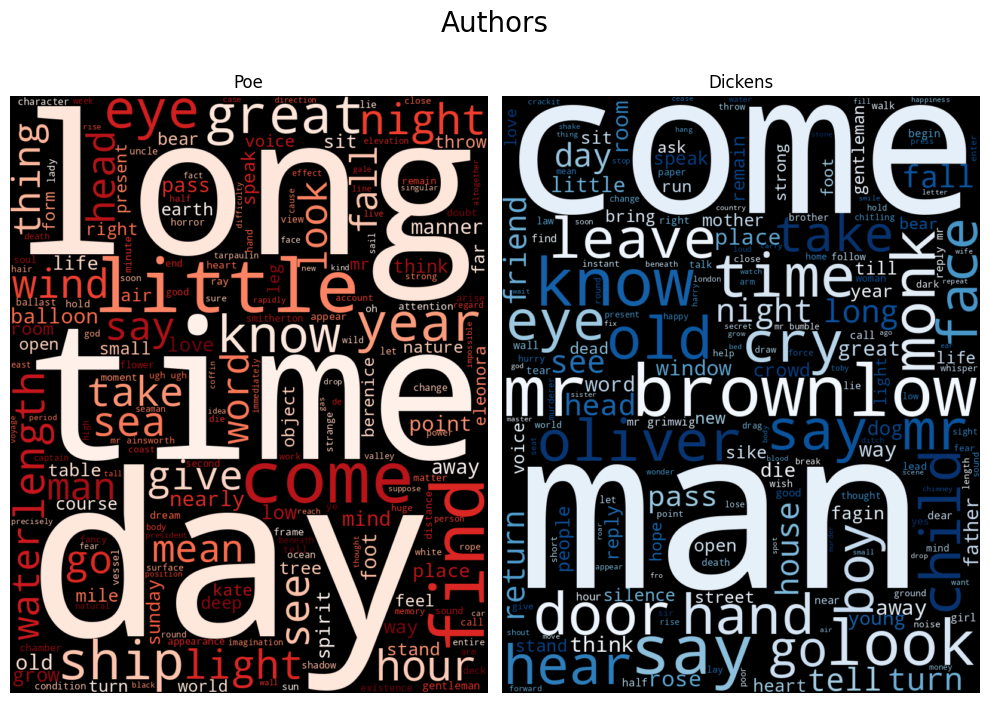

In [144]:
# Word clouds
poe_cloud = WordCloud(random_state = 42,
                      width = 800,
                      height = 1000,
                      min_word_length = 2, colormap="Reds",
                     ).generate(poe_lemmas)
dickens_cloud = WordCloud(random_state = 42,
                       width = 800,
                       height= 1000,
                       min_word_length = 2,
                       colormap="Blues",
                      ).generate(dickens_lemmas)
# Plot the wordclouds side by side
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(poe_cloud, interpolation='bilinear')
axes[0].set_title("Poe")
axes[1].imshow(dickens_cloud, interpolation='bilinear')
axes[1].set_title("Dickens")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Authors', fontsize=20, y=1.05);

In [145]:
poe_tokens_exploded_list = df.loc[filter_poe, 'tokens'].explode().astype(str).to_list()
poe_tokens_exploded_list[:20]

['additional',
 'information',
 'monday',
 'course',
 'teeth',
 'speck',
 'surface',
 'shade',
 'thought',
 'sure',
 'vision',
 'deceived',
 'calm',
 'flowers',
 'guile',
 'disguised',
 'fervor',
 'love',
 'animated',
 'came']

In [146]:
dickens_tokens_exploded_list = df.loc[filter_dickens, 'tokens'].explode().astype(str).to_list()
dickens_tokens_exploded_list[:20]

['harry',
 'soon',
 'seen',
 'friend',
 'safe',
 'coach',
 'perfect',
 'stillness',
 'ensued',
 'rustle',
 'breath',
 'guilty',
 'birth',
 'parentage',
 'proofs',
 'destroyed',
 'collect',
 'thoughts',
 'awhile',
 'began']

**Bigrams**

In [147]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [148]:
# Poe bigrams
bigram_finder_high = nltk.BigramCollocationFinder.from_words(poe_tokens_exploded_list)

bigrams_scores_poe = bigram_finder_high.score_ngrams(bigram_measures.raw_freq)
bigrams_scores_poe[:20]

[(('mr.', 'ainsworth'), 0.0009388691842269978),
 (('thousand', 'miles'), 0.0008345503859795535),
 (('guide', 'rope'), 0.0007302315877321093),
 (('valley', 'colored'), 0.0007302315877321093),
 (('colored', 'grass'), 0.0006259127894846651),
 (('captain', 'pratt'), 0.000521593991237221),
 (('dubble', 'l.'), 0.000521593991237221),
 (('king', 'pest'), 0.000521593991237221),
 (('l.', 'dee'), 0.000521593991237221),
 (('mr.', 'rumgudgeon'), 0.000521593991237221),
 (('25,000', 'feet'), 0.00041727519298977677),
 (('doctor', 'dubble'), 0.00041727519298977677),
 (('ha', 'ha'), 0.00041727519298977677),
 (('mr.', 'osborne'), 0.00041727519298977677),
 (('studding', 'sail'), 0.00041727519298977677),
 (('uncle', 'rumgudgeon'), 0.00041727519298977677),
 (('yesterday', 'sunday'), 0.00041727519298977677),
 (('1000', 'years'), 0.00031295639474233255),
 (('20', '1000'), 0.00031295639474233255),
 (('ana', 'pest'), 0.00031295639474233255)]

In [149]:
# Dickens bigrams
bigram_finder_dickens = nltk.BigramCollocationFinder.from_words(dickens_tokens_exploded_list)

bigrams_scores_dickens = bigram_finder_dickens.score_ngrams(bigram_measures.raw_freq)
bigrams_scores_dickens[:20]

[(('mr.', 'brownlow'), 0.008480372042128299),
 (('said', 'mr.'), 0.004924086992203529),
 (('mr.', 'grimwig'), 0.0019149227191902613),
 (('replied', 'mr.'), 0.0017781425249623855),
 (('mr.', 'bumble'), 0.0012310217480508822),
 (('said', 'monks'), 0.0010942415538230065),
 (('mrs.', 'maylie'), 0.0009574613595951306),
 (('old', 'gentleman'), 0.0009574613595951306),
 (('young', 'man'), 0.0009574613595951306),
 (('said', 'kags'), 0.0008206811653672548),
 (('mr.', 'losberne'), 0.000683900971139379),
 (('mrs.', 'bumble'), 0.000683900971139379),
 (('said', 'rose'), 0.000683900971139379),
 (('young', 'lady'), 0.000683900971139379),
 (('looking', 'round'), 0.0005471207769115032),
 (('old', 'man'), 0.0005471207769115032),
 (('asked', 'monks'), 0.0004103405826836274),
 (('asked', 'mr.'), 0.0004103405826836274),
 (('began', 'think'), 0.0004103405826836274),
 (('cried', 'boy'), 0.0004103405826836274)]

**Text Classification - Machine Learning**

In [150]:
X = df['text']
y = df['author']

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,
                                                    random_state=321)

In [152]:
# Vectorizer
count_vectorizer = CountVectorizer()
count_vectorizer.fit(X_train)

CountVectorizer()

In [153]:
X_train_counts = count_vectorizer.transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [154]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)

    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)

    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None,
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d",
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")

    # Create a confusion matrix with the data with normalize argument
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap,
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")

    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()

    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

     Dickens       1.00      1.00      1.00      1132
         Poe       1.00      1.00      1.00      1531

    accuracy                           1.00      2663
   macro avg       1.00      1.00      1.00      2663
weighted avg       1.00      1.00      1.00      2663



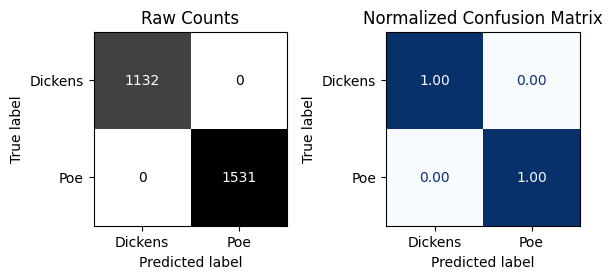


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

     Dickens       0.80      0.68      0.73       344
         Poe       0.81      0.89      0.85       544

    accuracy                           0.81       888
   macro avg       0.81      0.78      0.79       888
weighted avg       0.81      0.81      0.81       888



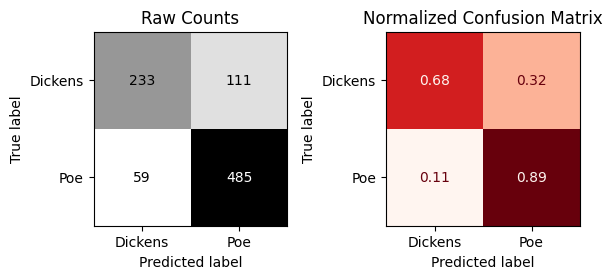

In [155]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_counts, y_train)
# metrics
evaluate_classification(clf, X_train_counts, y_train, X_test_counts, y_test)

In [156]:
# Model Pipeline
clf_pipe = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),
                     ('clf',RandomForestClassifier(random_state=42))])
clf_pipe

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

     Dickens       1.00      1.00      1.00      1132
         Poe       1.00      1.00      1.00      1531

    accuracy                           1.00      2663
   macro avg       1.00      1.00      1.00      2663
weighted avg       1.00      1.00      1.00      2663



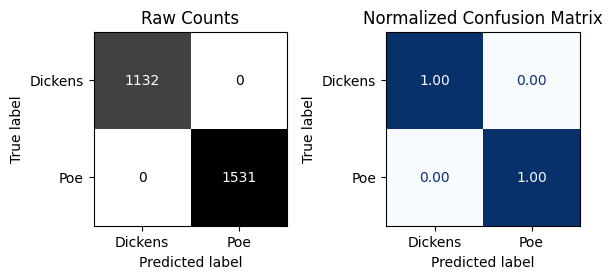


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

     Dickens       0.76      0.56      0.65       344
         Poe       0.76      0.89      0.82       544

    accuracy                           0.76       888
   macro avg       0.76      0.73      0.74       888
weighted avg       0.76      0.76      0.75       888



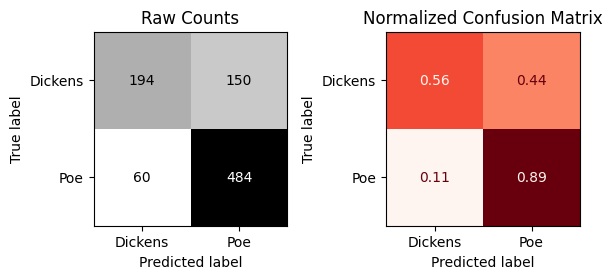

In [157]:
clf_pipe.fit(X_train, y_train)

evaluate_classification(clf_pipe, X_train,y_train, X_test, y_test)

In [158]:
#dump(clf_pipe, 'models/model_pipeline.joblib')

**Text Classification - Deep NLP**

In [159]:
batch_size = 32

In [160]:
df['author'].value_counts(normalize = True)

author
Poe        0.584342
Dickens    0.415658
Name: proportion, dtype: float64

In [161]:
label_encoder = LabelEncoder()
df['author_encoded'] = label_encoder.fit_transform(df['author'])
df

,author,text,tokens,lemmas,tokens-joined,lemmas-joined,author_encoded
0,Poe,additional information either on Monday ...,"[additional, information, monday, course]","[additional, information, monday, course]",additional information monday course,additional information monday course,1
1,Poe,teeth. Not a speck on their surface—not ...,"[teeth, speck, surface, shade]","[tooth, speck, surface, shade]",teeth speck surface shade,tooth speck surface shade,1
2,Dickens,“Harry? As soon as he had seen your friend her...,"[harry, soon, seen, friend, safe, coach]","[harry, soon, see, friend, safe, coach]",harry soon seen friend safe coach,harry soon see friend safe coach,0
3,Poe,thought—to make sure that my vision had ...,"[thought, sure, vision, deceived, calm]","[think, sure, vision, deceive, calm]",thought sure vision deceived calm,think sure vision deceive calm,1
4,Poe,the flowers. No guile disguised the ferv...,"[flowers, guile, disguised, fervor, love, anim...","[flower, guile, disguise, fervor, love, animate]",flowers guile disguised fervor love animated,flower guile disguise fervor love animate,1
...,...,...,...,...,...,...,...
3546,Poe,"condition of shadow and doubt, appertain...","[condition, shadow, doubt, appertaining, present]","[condition, shadow, doubt, appertain, present]",condition shadow doubt appertaining present,condition shadow doubt appertain present,1
3547,Poe,I left it for ever for the vanities and ...,"[left, vanities, turbulent, triumphs]","[leave, vanity, turbulent, triumph]",left vanities turbulent triumphs,leave vanity turbulent triumph,1
3548,Poe,"soul, to the most intense and painful me...","[soul, intense, painful, meditation, roaming]","[soul, intense, painful, meditation, roam]",soul intense painful meditation roaming,soul intense painful meditation roam,1
3549,Dickens,"upon the scenes of the past, resolved to amend...","[scenes, past, resolved, amend, new, sphere]","[scene, past, resolve, amend, new, sphere]",scenes past resolved amend new sphere,scene past resolve amend new sphere,0


In [162]:
df['paragraph_length'] = df['text'].apply(len)
df.max()

author                                                            Poe
text                “or is that little Oliver? Oh O-li-ver, if you...
tokens                                         [’em, people, jumping]
lemmas                                            [’em, people, jump]
tokens-joined                                      ’em people jumping
lemmas-joined                                         ’em people jump
author_encoded                                                      1
paragraph_length                                                   71
dtype: object

In [163]:
df

,author,text,tokens,lemmas,tokens-joined,lemmas-joined,author_encoded,paragraph_length
0,Poe,additional information either on Monday ...,"[additional, information, monday, course]","[additional, information, monday, course]",additional information monday course,additional information monday course,1,69
1,Poe,teeth. Not a speck on their surface—not ...,"[teeth, speck, surface, shade]","[tooth, speck, surface, shade]",teeth speck surface shade,tooth speck surface shade,1,62
2,Dickens,“Harry? As soon as he had seen your friend her...,"[harry, soon, seen, friend, safe, coach]","[harry, soon, see, friend, safe, coach]",harry soon seen friend safe coach,harry soon see friend safe coach,0,69
3,Poe,thought—to make sure that my vision had ...,"[thought, sure, vision, deceived, calm]","[think, sure, vision, deceive, calm]",thought sure vision deceived calm,think sure vision deceive calm,1,69
4,Poe,the flowers. No guile disguised the ferv...,"[flowers, guile, disguised, fervor, love, anim...","[flower, guile, disguise, fervor, love, animate]",flowers guile disguised fervor love animated,flower guile disguise fervor love animate,1,71
...,...,...,...,...,...,...,...,...
3546,Poe,"condition of shadow and doubt, appertain...","[condition, shadow, doubt, appertaining, present]","[condition, shadow, doubt, appertain, present]",condition shadow doubt appertaining present,condition shadow doubt appertain present,1,69
3547,Poe,I left it for ever for the vanities and ...,"[left, vanities, turbulent, triumphs]","[leave, vanity, turbulent, triumph]",left vanities turbulent triumphs,leave vanity turbulent triumph,1,71
3548,Poe,"soul, to the most intense and painful me...","[soul, intense, painful, meditation, roaming]","[soul, intense, painful, meditation, roam]",soul intense painful meditation roaming,soul intense painful meditation roam,1,67
3549,Dickens,"upon the scenes of the past, resolved to amend...","[scenes, past, resolved, amend, new, sphere]","[scene, past, resolve, amend, new, sphere]",scenes past resolved amend new sphere,scene past resolve amend new sphere,0,71


In [164]:
X = df['text'].values
X

array(['      additional information either on Monday or in the course of the',
       '      teeth. Not a speck on their surface—not a shade on their',
       '“Harry? As soon as he had seen your friend here, safe in a coach with',
       ...,
       '      soul, to the most intense and painful meditation—she, roaming',
       'upon the scenes of the past, resolved to amend it in some new sphere of',
       'distinctness, looked towards his counsel, in mute appeal that he would,'],
      dtype=object)

In [165]:
y= df['author_encoded']
y.value_counts()

author_encoded
1    2075
0    1476
Name: count, dtype: int64

In [166]:
classes = y.unique()
classes

array([1, 0])

In [167]:
SEQUENCE_LENGTH = 71
EMBED_DIM = 100

# Text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH)

In [168]:
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

2

In [173]:
def build_gru_model_bi_pool(text_vectorization_layer, VOCAB_SIZE, EMBED_DIM, SEQUENCE_LENGTH, classes):
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_DIM, input_length=SEQUENCE_LENGTH),
        layers.Bidirectional(layers.GRU(128, return_sequences=True)),
        layers.GlobalMaxPooling1D(),
        layers.Dense(len(classes), activation='softmax')
    ])

    optimizer = optimizers.Adam()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [170]:
# def get_callbacks(patience=3, monitor='val_accuracy'):
#     early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
#     return [early_stop]

In [175]:
# Assuming VOCAB_SIZE, EMBED_DIM, SEQUENCE_LENGTH, and classes are defined
model = build_gru_model_bi_pool(sequence_vectorizer, VOCAB_SIZE, EMBED_DIM, SEQUENCE_LENGTH, classes)

# Build the model before printing the summary
model.build(input_shape=(None, SEQUENCE_LENGTH))

# Print model summary
model.summary()

ValueError: Exception encountered when calling layer 'text_vectorization_4' (type TextVectorization).

When using `TextVectorization` to tokenize strings, the input rank must be 1 or the last shape dimension must be 1. Received: inputs.shape=(None, 71) with rank=2

Call arguments received by layer 'text_vectorization_4' (type TextVectorization):
  • inputs=tf.Tensor(shape=(None, 71), dtype=float32)